##### import

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model 
import random
from tensorflow.keras.layers import (
    Dense, Flatten, Input, Add, Conv2D, MaxPooling2D, LeakyReLU
)

from tensorflow.keras import Model
import matplotlib.pyplot as plt
keras.backend.image_data_format()
keras.backend.set_image_data_format('channels_last')

##### 各label100枚ずつの学習用データの作成

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data() # mnistのload

In [3]:
import pandas as pd

#各label100枚ずつ足りだすためのコード、pandasを用いて行う
df = pd.DataFrame(columns=["label"])
df["label"] = y_train.reshape([-1])

list_0 = df.loc[df.label==0].sample(n=100)#n=100でsampling
list_1 = df.loc[df.label==1].sample(n=100)
list_2 = df.loc[df.label==2].sample(n=100)
list_3 = df.loc[df.label==3].sample(n=100)
list_4 = df.loc[df.label==4].sample(n=100)
list_5 = df.loc[df.label==5].sample(n=100)
list_6 = df.loc[df.label==6].sample(n=100)
list_7 = df.loc[df.label==7].sample(n=100)
list_8 = df.loc[df.label==8].sample(n=100)
list_9 = df.loc[df.label==9].sample(n=100)

label_list = pd.concat([list_0,list_1,list_2,list_3,list_4,list_5,list_6,list_7,list_8,
                       list_9])
label_list = label_list.sort_index()
label_idx = label_list.index.values

train_label = label_list.label.values

"""
x_trainからlabel用のdataframe.indexを取り出すことでlabelに対応したデータを取り出す。
"""
x_train = x_train[label_idx]
y_train= train_label
x_train = x_train / 255
x_test = x_test / 255

In [4]:
x_train.shape #100 * 10なので1000になっていることが分かる

(1000, 28, 28)

In [5]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.reshape([len(y_train),1]))

In [6]:
from sklearn.model_selection import train_test_split
x_train , x_val , y_train , y_val = train_test_split(x_train,y_train,test_size=0.2)

### 改良前のcnn model

In [7]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(2020)

cnnを使用した分類modelの作成

In [8]:
inp = Input(shape=(28,28,1),name="inp2")
p3 = Conv2D(32,2,2,padding="same")(inp)
p3 = Conv2D(16,2,2,padding="same")(p3)
p3 = MaxPooling2D(2,2,padding="same")(p3)
p3 = Conv2D(8,2,2,padding="same")(p3)
p3 = MaxPooling2D(2,2,padding="same")(p3)
p3 = Conv2D(8,2,2,padding="same")(p3)
p3 = MaxPooling2D(2,2,padding="same")(p3)
p3 = Flatten()(p3)
p3 = Dense(128,activation="relu")(p3)
p3 = Dense(64,activation="relu")(p3)
out = Dense(10,activation="softmax")(p3)

In [9]:
model = Model(inp,out)
model.compile(optimizer='adam', 
              loss="categorical_crossentropy", 
              metrics="acc")

##### modelの可視化

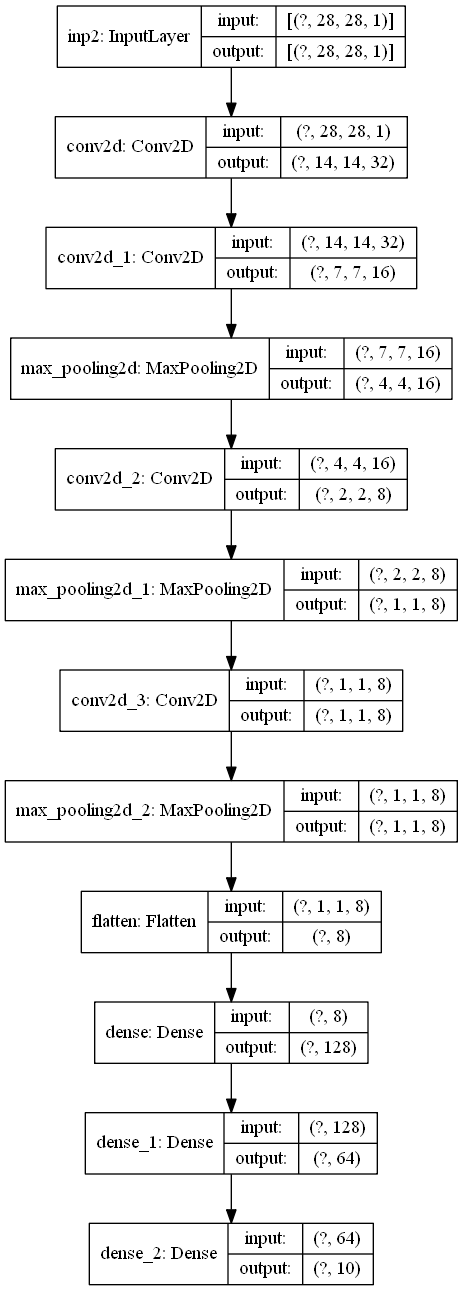

In [10]:
from keras.utils import plot_model
plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
)

In [11]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, mode='auto') 

model.fit(x =x_train,
          y=y_train, 
          epochs=10000, 
          batch_size=8, 
          shuffle=True, 
          validation_data=(x_val,y_val), 
          callbacks=[early_stopping]
         )

Epoch 1/10000
100/100 [==============================] - 0s 4ms/step - loss: 2.2860 - acc: 0.1250 - val_loss: 2.2386 - val_acc: 0.1500
Epoch 2/10000
100/100 [==============================] - 0s 2ms/step - loss: 1.9977 - acc: 0.2575 - val_loss: 1.7996 - val_acc: 0.3200
Epoch 3/10000
100/100 [==============================] - 0s 3ms/step - loss: 1.6415 - acc: 0.3825 - val_loss: 1.6337 - val_acc: 0.3650
Epoch 4/10000
100/100 [==============================] - 0s 2ms/step - loss: 1.4488 - acc: 0.4475 - val_loss: 1.4533 - val_acc: 0.4500
Epoch 5/10000
100/100 [==============================] - 0s 2ms/step - loss: 1.2776 - acc: 0.5325 - val_loss: 1.3028 - val_acc: 0.5000
Epoch 6/10000
100/100 [==============================] - 0s 2ms/step - loss: 1.1254 - acc: 0.5863 - val_loss: 1.2225 - val_acc: 0.5450
Epoch 7/10000
100/100 [==============================] - 0s 2ms/step - loss: 0.9990 - acc: 0.6275 - val_loss: 1.1432 - val_acc: 0.6000
Epoch 8/10000
100/100 [==============================] 

In [12]:
pred_labels = model.predict(x_test)

In [13]:
pred = []
for label in pred_labels:
    idx = label.argmax()
    pred.append(idx)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,pred))

0.7464


改良前のmodelではacc_scoreは0.7464を出力している。

In [14]:
del model

#### autorncoderを用いてcnn modelの改良を行う
cnn modelの形状は変更しないものとする

In [15]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(2020)

In [16]:
#autoencoder部
input_img = Input(shape=(784,),name="inp1")
x= Dense(256, activation="relu")(input_img)
x = Dense(128,activation="relu")(x)
encoded = Dense(128, activation="relu")(x)

z = Dense(128, activation="relu")(encoded)
decoded = Dense(784, activation="sigmoid",name="decoded")(z)

#autoencoderの中間層からの出力を受け取り全結合
p2 = Dense(128,activation="relu")(encoded)
p2 = Dense(64,activation="relu")(p2)

#比べる対象cnn model、構造は改良前と同一なもの
inp = Input(shape=(28,28,1),name="inp2")
p3 = Conv2D(32,2,2,padding="same")(inp)
p3 = Conv2D(16,2,2,padding="same")(p3)
p3 = MaxPooling2D(2,2,padding="same")(p3)
p3 = Conv2D(8,2,2,padding="same")(p3)
p3 = MaxPooling2D(2,2,padding="same")(p3)
p3 = Conv2D(8,2,2,padding="same")(p3)
p3 = MaxPooling2D(2,2,padding="same")(p3)
p3 = Flatten()(p3)
p3 = Dense(128,activation="relu")(p3)
p3 = Dense(64,activation="relu")(p3)

p = Add()([p2,p3])
p = Dense(32,activation="relu")(p)
predictor = Dense(10,activation="softmax",name="predictor")(p)

#各層をmultiple inputs outputsとしてcompile
model = Model(inputs=[input_img,inp], outputs=[decoded,predictor])
model.compile(optimizer='adam', 
              loss={"decoded":"mse","predictor":"categorical_crossentropy"}, 
              metrics={"predictor":"acc"})

##### modelの可視化

In [17]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp2 (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   160         inp2[0][0]                       
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 16)     2064        conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 4, 4, 16)     0           conv2d_5[0][0]                   
_______________________________________________________________________________________

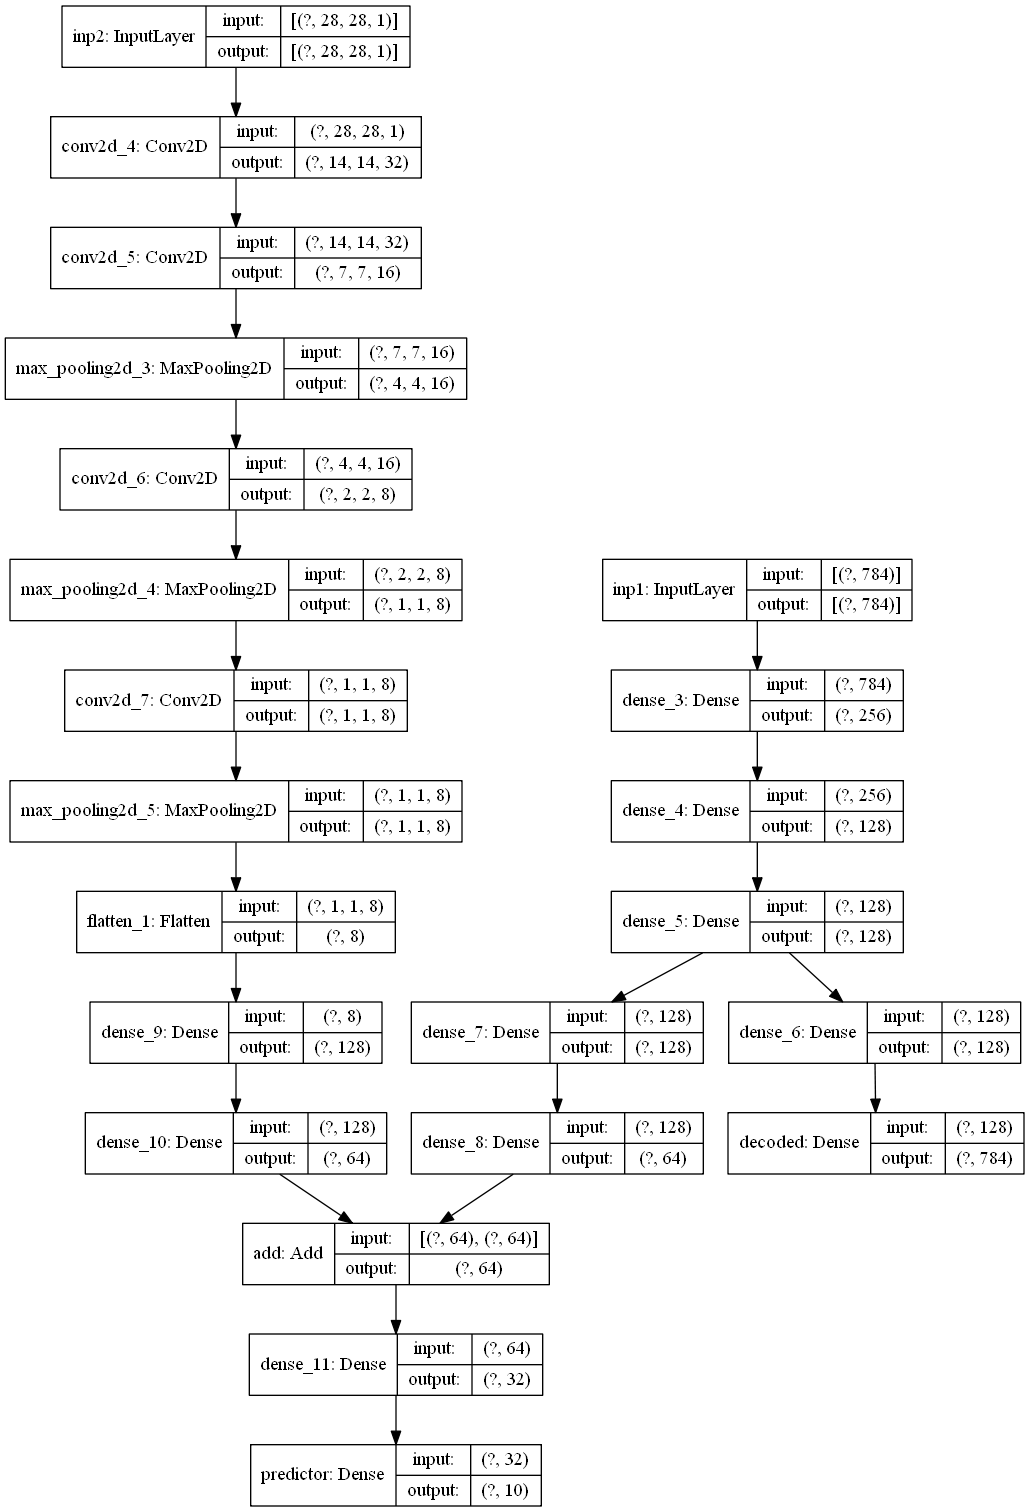

In [18]:
plot_model(
    model,
    to_file='model_after.png',
    show_shapes=True,
)

In [19]:
x_train_1 = x_train.reshape(len(x_train),784,1)
x_train_2 = x_train.reshape(len(x_train),28,28,1)

x_val_1 = x_val.reshape(len(x_val),784,1)
x_val_2 = x_val.reshape(len(x_val),28,28,1)

In [20]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor='val_predictor_loss', min_delta=0.00001, patience=10, mode='auto') 

model.fit(x = {"inp1":x_train_1,"inp2":x_train_2},
          y={"decoded":x_train_1,"predictor":y_train}, 
          epochs=10000, 
          batch_size=8, 
          shuffle=True, 
          validation_data=({"inp1":x_val_1,"inp2":x_val_2}, {"decoded":x_val_1,"predictor":y_val}), 
          callbacks=[early_stopping]
         )

Epoch 1/10000
100/100 [==============================] - 0s 5ms/step - loss: 1.5771 - decoded_loss: 0.0945 - predictor_loss: 1.4826 - predictor_acc: 0.5038 - val_loss: 1.1179 - val_decoded_loss: 0.0599 - val_predictor_loss: 1.0580 - val_predictor_acc: 0.6600
Epoch 2/10000
100/100 [==============================] - 0s 3ms/step - loss: 0.6398 - decoded_loss: 0.0569 - predictor_loss: 0.5829 - predictor_acc: 0.8200 - val_loss: 0.8113 - val_decoded_loss: 0.0530 - val_predictor_loss: 0.7583 - val_predictor_acc: 0.7650
Epoch 3/10000
100/100 [==============================] - 0s 3ms/step - loss: 0.4338 - decoded_loss: 0.0524 - predictor_loss: 0.3814 - predictor_acc: 0.8700 - val_loss: 0.7595 - val_decoded_loss: 0.0507 - val_predictor_loss: 0.7088 - val_predictor_acc: 0.7500
Epoch 4/10000
100/100 [==============================] - 0s 3ms/step - loss: 0.3216 - decoded_loss: 0.0505 - predictor_loss: 0.2710 - predictor_acc: 0.9225 - val_loss: 0.5286 - val_decoded_loss: 0.0489 - val_predictor_loss:

In [21]:
x_test_1 = x_test.reshape(len(x_test),784,1)
x_test_2 = x_test.reshape(len(x_test),28,28,1)

In [22]:
pred_img ,pred_labels = model.predict({"inp1":x_test_1,"inp2":x_test_2})

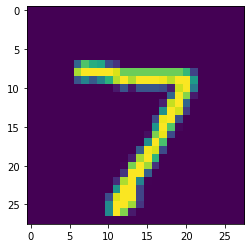

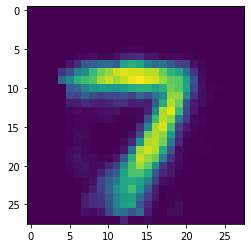

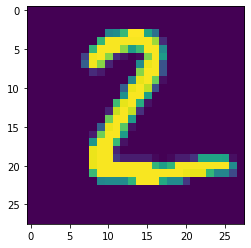

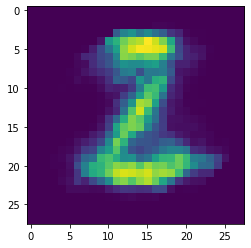

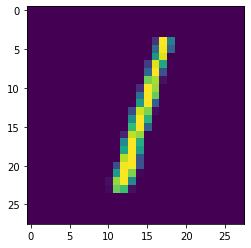

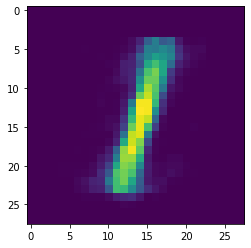

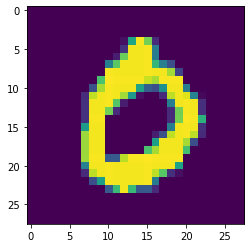

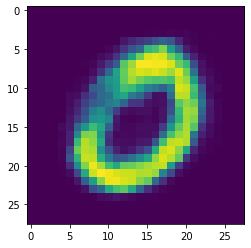

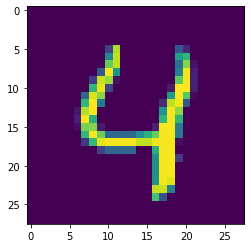

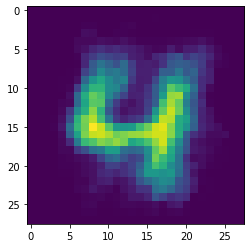

In [23]:
#autoencoderの出力
for i in range(5):
    fig , ax = plt.subplots()
    x_test = x_test.reshape(len(x_test),28,28)
    ax.imshow(x_test[i])
    
    fig , ax = plt.subplots()
    pred_img = pred_img.reshape(len(pred_img),28,28)
    ax.imshow(pred_img[i])

    plt.show()

In [24]:
pred = []
for label in pred_labels:
    idx = label.argmax()
    pred.append(idx)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,pred))

0.9055


In [25]:
del model

autoencoderを用いてcnn modelの改良を行うと0.9027の正解率を出力した。

各正解率を比べる。

改良前:0.7748

改良後:0.9055

シンプルなcnnにシンプルなautoencoderを用いて改良を加えることで精度の向上が見られた。